In [2]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

In [3]:
gdal.UseExceptions()

ds = gdal.Open('USGS_one_meter_x28y430_MD_VA_Sandy_NCR_2014.tif')
band = ds.GetRasterBand(1)
elevation1 = band.ReadAsArray()

In [4]:
eval1_proc = np.copy(elevation1[:500,2370:2870])
nan_exist = 0
for i, line in enumerate(eval1_proc):
    for j, el in enumerate(line):
        if el < -1000:
#             eval1_proc[i][j] = np.nan
            eval1_proc[i][j] = 50
            nan_exist = 1
if nan_exist:
    print('missed value')
            
# print(eval1_proc.shape, eval1_proc)

missed value
(500, 500) [[50.405243 50.386574 50.379475 ... 57.58232  57.675182 57.715313]
 [50.384705 50.39285  50.365475 ... 57.607533 57.642944 57.65451 ]
 [50.390594 50.387573 50.358967 ... 57.56188  57.628498 57.642128]
 ...
 [50.       50.       50.       ... 53.50899  53.569653 53.58676 ]
 [50.       50.       50.       ... 53.53948  53.563183 53.533592]
 [50.       50.       50.       ... 53.510677 53.54195  53.519684]]


<Figure size 8000x8000 with 0 Axes>

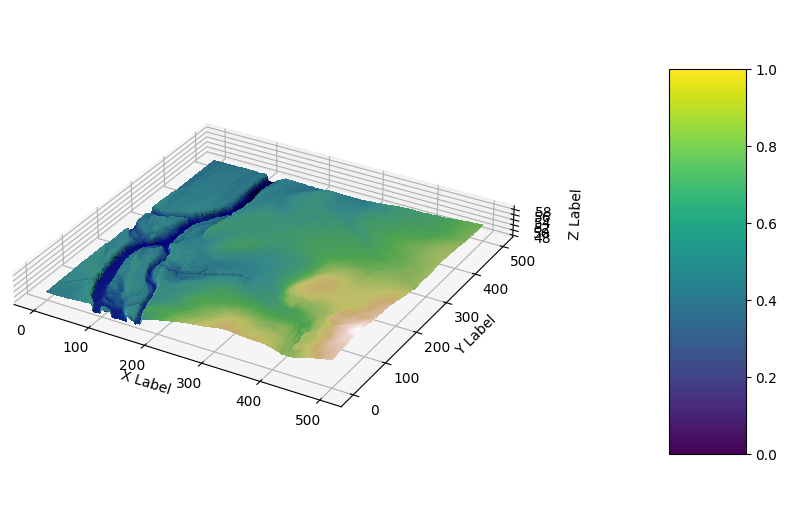

In [6]:
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.colors import LightSource

plt.figure(figsize=(10, 10), dpi=800)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(eval1_proc.shape[0])
y = np.arange(eval1_proc.shape[1])
X, Y = np.meshgrid(x, y)


z = np.ravel(eval1_proc)
Z = z.reshape(X.shape)



ls = LightSource(270, 45)
rgb = ls.shade(Z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False, vmin=-1000, vmax=5000)

fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.gcf().set_size_inches(10, 10) #figure size
ax.set_box_aspect(aspect = (10,10,1)) #changing the scale of Z axes to avoid "jumps"
# ax.set_zlim(40, 55)

plt.show()